In [ ]:
!nvidia-smi

Wed May 19 06:37:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-29nbsn5g
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-29nbsn5g
     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 245kB 5.8MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp37-none-any.whl size=83164 sha256=f2e9603eedc2b1528841570aa5ac1d1564e35eed3ddfde18532c3e13ba3596ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw4_ru6e/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=01c026a92bb7e3919f4ebfdafa2de1142729b549143fffc8b31e4164a804a596
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-non

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2
from collections import defaultdict
from sklearn.model_selection import train_test_split
import albumentations as A

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

from sklearn.model_selection import train_test_split
import glob

In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

wb = gc.open_by_key('15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps')

In [ ]:
!unzip /content/drive/MyDrive/SeniorProject/Dataset/wongnai/Food_Segmentation.zip

Archive:  /content/drive/MyDrive/SeniorProject/Dataset/wongnai/Food_Segmentation.zip
   creating: Food_Segmentation/
  inflating: Food_Segmentation/.DS_Store  
  inflating: __MACOSX/Food_Segmentation/._.DS_Store  
   creating: Food_Segmentation/train/
   creating: Food_Segmentation/val/
  inflating: Food_Segmentation/train/.DS_Store  
  inflating: __MACOSX/Food_Segmentation/train/._.DS_Store  
   creating: Food_Segmentation/train/img/
   creating: Food_Segmentation/train/mask/
  inflating: Food_Segmentation/val/.DS_Store  
  inflating: __MACOSX/Food_Segmentation/val/._.DS_Store  
   creating: Food_Segmentation/val/img/
   creating: Food_Segmentation/val/mask/
  inflating: Food_Segmentation/train/img/21856.jpg  
  inflating: Food_Segmentation/train/img/krapao156.jpg  
  inflating: Food_Segmentation/train/img/rice222.jpg  
  inflating: Food_Segmentation/train/img/34268.jpg  
  inflating: Food_Segmentation/train/img/1179.jpg  
  inflating: Food_Segmentation/train/img/14557.jpg  
  inflati

In [ ]:
food_seg_path = '/content/drive/MyDrive/SeniorProject/Dataset/wongnai/Food Seg-14.json'
beverage_path = '/content/beverage/beverage.json'

In [ ]:
img_id_to_categories_id = dict()

In [ ]:
img_id_2_filename = dict()

In [ ]:
with open(food_seg_path, "r") as read_file:
    foodseg_annotation = json.load(read_file)

In [ ]:
for i in foodseg_annotation['annotations']:
    if i['image_id'] not in img_id_to_categories_id:
        img_id_to_categories_id[i['image_id']] = []

    a =(5, i['segmentation'])
    img_id_to_categories_id[i['image_id']].append(a)

In [ ]:
for img in foodseg_annotation['images']:
    img_id_2_filename[img['id']] = img['file_name']

In [ ]:
#This algorithm for split train test dataset by using its classes
img_id = []
classes = []
_d = dict()
dd = dict()

for k,v in img_id_to_categories_id.items():
  if k not in _d:
    _d[k] = []
  count = 0
  
  for i in v:
    if i[0] not in _d[k]:
      _d[k].append(i[0])
      count+= (2**i[0])

  classes.append(count)
  img_id.append(k)

In [ ]:
dd = dict()
unique_value = []
for i in classes:
  if i not in dd:
    dd[i]=0
  dd[i]+=1

for i in dd:
  if dd[i]==1:
    unique_value.append(i)

In [ ]:
for i in unique_value:
  idx = classes.index(i)
  classes.pop(idx)
  img_id.pop(idx)

In [ ]:
beverage_path = './beverage/img/'
beverage_mask_path = './beverage/mask/'
beverage_img = []
beverage_mask = []
for b in os.listdir(beverage_path):
  if '.DS' not in b:
    beverage_img.append(os.path.join(beverage_path, b))
for b in os.listdir(beverage_mask_path):
  if '.DS' not in b:
    beverage_mask.append(os.path.join(beverage_mask_path, b))

In [ ]:
for i in range(len(beverage_img)):
  if beverage_img[i].split('/')[3] != beverage_mask[i].split('/')[3]:
    print(beverage_img[i])

In [ ]:
wongnai_list_of_train_id, wongnai_list_of_val_id, classes_train, classes_val = train_test_split(img_id, classes, test_size = 0.2, stratify = classes, random_state=0)
beverage_train_path, beverage_val_path, beverage_mask_train_path, beverage_mask_val_path = train_test_split(beverage_img, beverage_mask, test_size = 0.1, random_state=0)

In [ ]:
x_train_dir = []
y_train_dir = []
x_val_dir = []
y_val_dir = []

for id in wongnai_list_of_train_id:
  x_train_dir.append('./Food Seg/{}'.format(img_id_2_filename[id]))
  y_train_dir.append('./mask/{}'.format(img_id_2_filename[id]))

x_train_dir += beverage_train_path
y_train_dir += beverage_mask_train_path
# y_train_dir += beverage_mask_val_path

for id in wongnai_list_of_val_id:
  x_val_dir.append('./Food Seg/{}'.format(img_id_2_filename[id]))
  y_val_dir.append('./mask/{}'.format(img_id_2_filename[id]))

x_val_dir += beverage_val_path
y_val_dir += beverage_mask_val_path

In [ ]:
x_train_dir = glob.glob('./Food_Segmentation/train/img/*')
y_train_dir = glob.glob('./Food_Segmentation/train/mask/*')
x_val_dir = glob.glob('./Food_Segmentation/val/img/*')
y_val_dir = glob.glob('./Food_Segmentation/val/mask/*')

In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [ ]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = images_dir
        self.images = images_dir
        self.masks = masks_dir
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[i], 0)
        # mask = mask.astype('float')
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

    def remove(self, i):
        self.ids.pop(i)
        self.images.pop(i)
        self.masks.pop(i)

In [ ]:
import albumentations as albu

In [ ]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        # albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.geometric.resize.Resize(320,320),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        # albu.PadIfNeeded(384, 480),
        albu.geometric.resize.Resize(320,320),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
dataset = Dataset(x_train_dir, y_train_dir, classes=['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.'], augmentation=get_training_augmentation())

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
from collections import defaultdict
counting_pixel = defaultdict(lambda:0)
for train_img in dataset:
  y_true = train_img[1]
  y_true = np.argmax(y_true, axis=-1)
  y_true = y_true.flatten()
  unique, counts = np.unique(y_true, return_counts=True)
  for idx, i in enumerate(unique):
    counting_pixel[i]+=counts[idx]

In [ ]:
dict(zip(list(counting_pixel.keys())[1:], list(counting_pixel.values())[1:]/sum(list(counting_pixel.values())[1:])*100))

{1: 17.89004644336351,
 2: 21.903248306935794,
 3: 16.607226395097438,
 4: 18.406416947726985,
 5: 16.90550646617195,
 6: 8.287555440704324}

In [ ]:
dataset_val = Dataset(x_val_dir, y_val_dir, classes=['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.'], augmentation=get_validation_augmentation())

In [ ]:
from collections import defaultdict
counting_pixel = defaultdict(lambda:0)
for train_img in dataset_val:
  y_true = train_img[1]
  y_true = np.argmax(y_true, axis=-1)
  y_true = y_true.flatten()
  unique, counts = np.unique(y_true, return_counts=True)
  for idx, i in enumerate(unique):
    counting_pixel[i]+=counts[idx]

In [ ]:
dict(zip(list(counting_pixel.keys())[1:], list(counting_pixel.values())[1:]/sum(list(counting_pixel.values())[1:])*100))

{1: 20.831491689075317,
 2: 18.37328869662915,
 3: 18.10761666044072,
 4: 16.489678712683535,
 5: 18.886382668487876,
 6: 7.311541572683401}

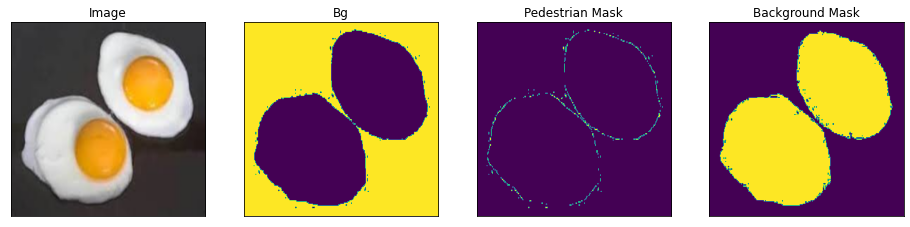

In [ ]:
#### Visualize resulted augmented images and masks
augmented_dataset = Dataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=get_validation_augmentation(), 
    classes=['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.']
)

# same image with different random transforms
# Lets look at augmented data we have

image, mask = dataset_val[15] # get some sample
visualize(
    image=image, 
    BG=mask[..., 0].squeeze(),
    pedestrian_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 3].squeeze(),
)

In [ ]:
mask.shape

(320, 320, 7)

In [ ]:
augmented_dataset[1][0].shape

(512, 512, 3)

In [ ]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [ ]:
model_name = "Unet++"

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.']
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES)+1, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:220: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:198: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
loss = smp.losses.FocalLoss(mode='multilabel')
loss.__name__ = 'focal_loss'

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
epoch_data = []
train_focal_loss = []
train_iou_score = []
valid_focal_loss = []
valid_iou_score = []

In [ ]:
# train model for 40 epochs

max_score = 0
counting_early_stopping = 0
minn_loss = 1000
for i in range(0, 10000):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    epoch_data.append(i)
    train_focal_loss.append(train_logs['focal_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_focal_loss.append(valid_logs['focal_loss'])
    valid_iou_score.append(valid_logs['iou_score'])
    
    if valid_logs['focal_loss'] < minn_loss:
      minn_loss = valid_logs['focal_loss']
      
    if valid_logs['focal_loss'] > minn_loss:
      counting_early_stopping +=1 

    if counting_early_stopping > 30:break

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model.state_dict(), '/content/drive/MyDrive/SeniorProject/Weight/pytorch/{}_{}.pt'.format(model_name, ENCODER))
        print('Model saved!')
        
    if counting_early_stopping == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


valid: 100%|██████████| 122/122 [00:04<00:00, 26.10it/s, focal_loss - 0.1859, iou_score - 0.5257]
Model saved!

Epoch: 1
valid: 100%|██████████| 122/122 [00:04<00:00, 25.92it/s, focal_loss - 0.1744, iou_score - 0.6585]
Model saved!

Epoch: 2
valid: 100%|██████████| 122/122 [00:04<00:00, 26.10it/s, focal_loss - 0.1719, iou_score - 0.6707]
Model saved!

Epoch: 3
valid: 100%|██████████| 122/122 [00:04<00:00, 26.06it/s, focal_loss - 0.1689, iou_score - 0.7242]
Model saved!

Epoch: 4
valid: 100%|██████████| 122/122 [00:04<00:00, 26.27it/s, focal_loss - 0.1674, iou_score - 0.754]
Model saved!

Epoch: 5
valid: 100%|██████████| 122/122 [00:04<00:00, 26.05it/s, focal_loss - 0.1655, iou_score - 0.7828]
Model saved!

Epoch: 6
valid: 100%|██████████| 122/122 [00:04<00:00, 25.90it/s, focal_loss - 0.164, iou_score - 0.799]
Model saved!

Epoch: 7
valid: 100%|██████████| 122/122 [00:04<00:00, 26.36it/s, focal_loss - 0.1666, iou_score - 0.7569]

Epoch: 8
valid: 100%|██████████| 122/122 [00:04<00:00, 25

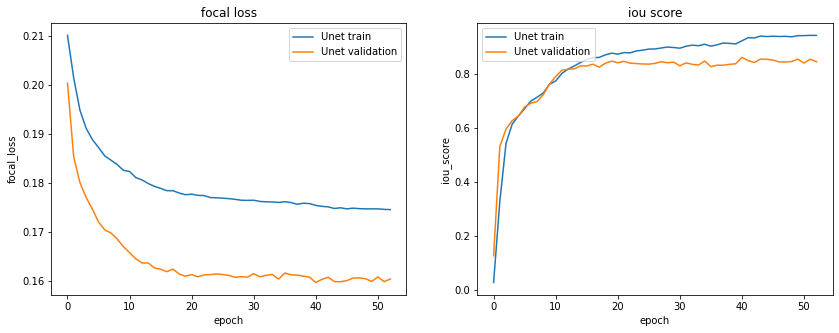

In [ ]:
fig = plt.figure(figsize=(14, 5))
 
ax1 = fig.add_subplot(1, 2, 1)
# line1, = ax1.plot(dlv3_x_epoch_data,dlv3_train_dice_loss,label='DeepLabV3+ train') 
# line2, = ax1.plot(dlv3_x_epoch_data,dlv3_valid_dice_loss,label='DeepLabV3+ validation')
line3, = ax1.plot(unet_x_epoch_data,unet_train_focal_loss,label='Unet train') 
line4, = ax1.plot(unet_x_epoch_data,unet_valid_focal_loss,label='Unet validation')
ax1.set_title("focal loss")
ax1.set_xlabel('epoch')
ax1.set_ylabel('focal_loss')
ax1.legend(loc='upper right')

ax2 = fig.add_subplot(1, 2, 2)
# line1, = ax2.plot(dlv3_x_epoch_data,dlv3_train_iou_score,label='DeepLabV3+ train')
# line2, = ax2.plot(dlv3_x_epoch_data,dlv3_valid_iou_score,label='DeepLabV3+ validation') 
line3, = ax2.plot(unet_x_epoch_data,unet_train_iou_score,label='Unet train')
line4, = ax2.plot(unet_x_epoch_data,unet_valid_iou_score,label='Unet validation') 
ax2.set_title("iou score")
ax2.set_xlabel('epoch')
ax2.set_ylabel('iou_score')
ax2.legend(loc='upper left')

plt.show()

In [ ]:
sheet_name = '{} {}'.format(model_name, ENCODER)

In [ ]:
wb.add_worksheet(sheet_name, 200, 200)

<Worksheet 'Unet++ resnet101' id:966915143>

In [ ]:
ws = wb.worksheet(sheet_name)

In [ ]:
for i in range(len(train_focal_loss)-1, -1,-1):
  train_iou = train_iou_score[i]
  val_iou = valid_iou_score[i]
  focal_loss_train = train_focal_loss[i]
  focal_loss_val = valid_focal_loss[i]
  ws.insert_row([train_iou, val_iou, focal_loss_train, focal_loss_val])

In [ ]:
cols = ['train_iou_score', 'val_iou_score', 'train_focal_loss', 'val_focal_loss']
ws.insert_row(cols)

{'spreadsheetId': '15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps',
 'updatedCells': 4,
 'updatedColumns': 4,
 'updatedRange': "'Unet++ resnet101'!A1:D1",
 'updatedRows': 1}

In [ ]:
test_dataset = Dataset(
    x_val_dir, 
    y_val_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

In [ ]:
test_dataset_vis = Dataset(
    x_val_dir, y_val_dir, 
    classes=CLASSES,
)

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


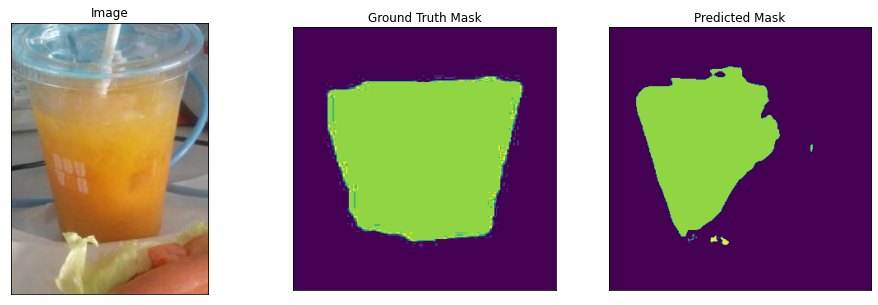

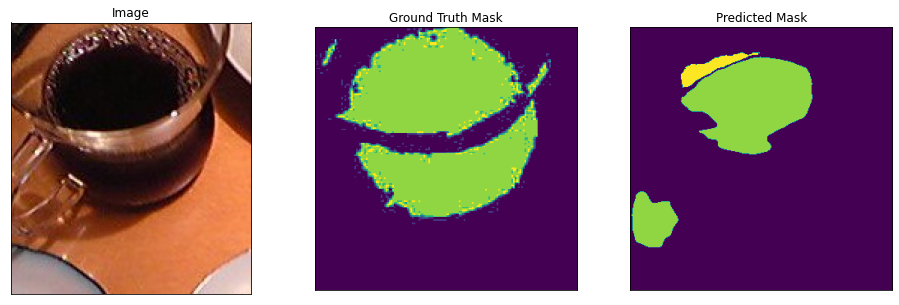

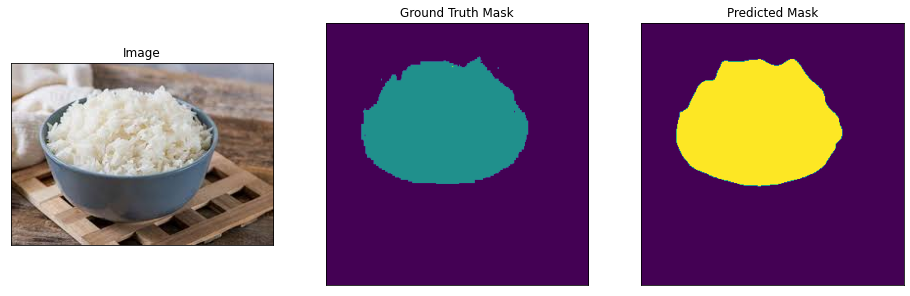

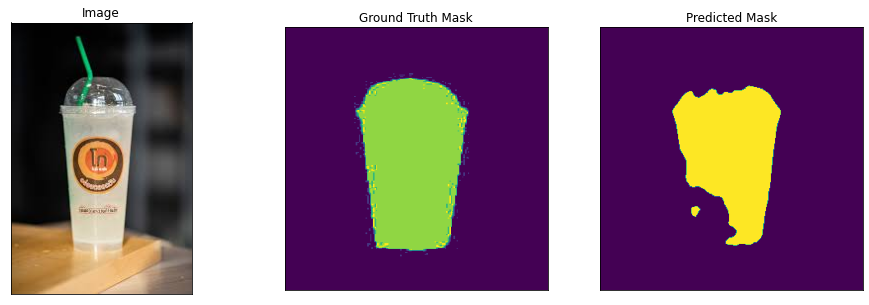

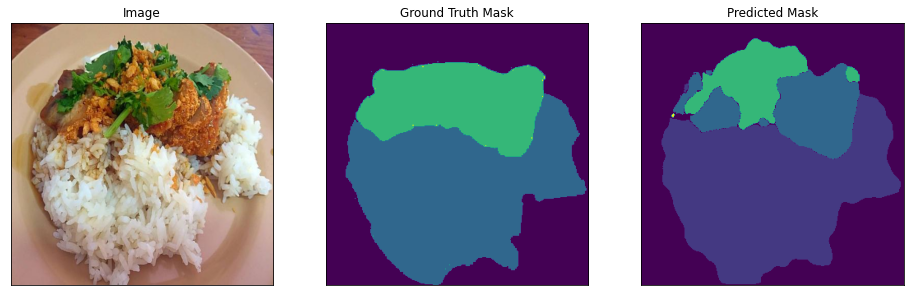

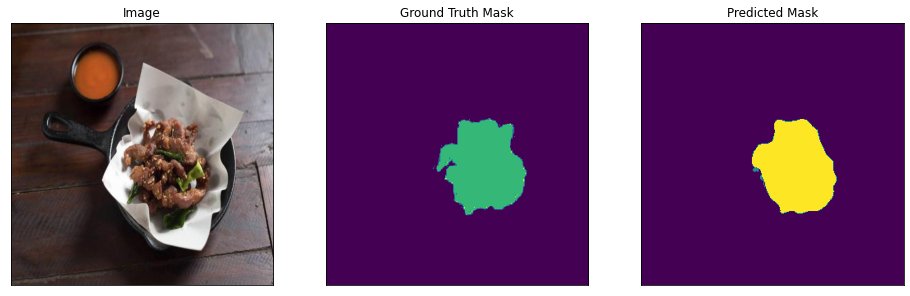

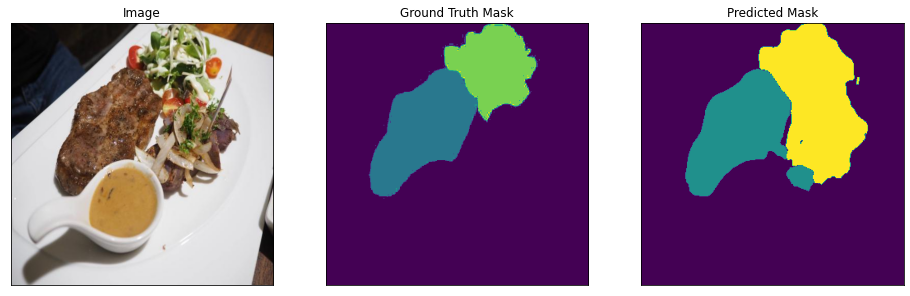

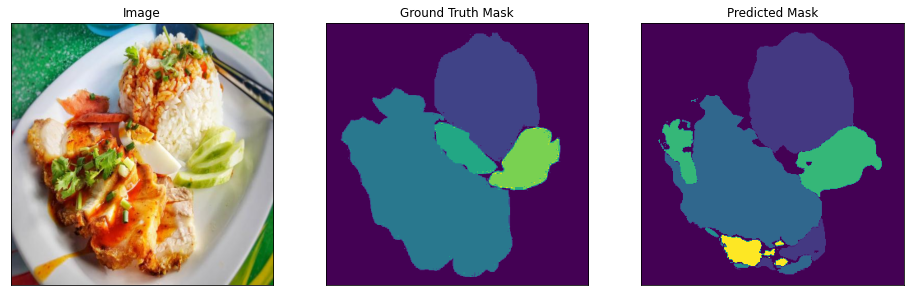

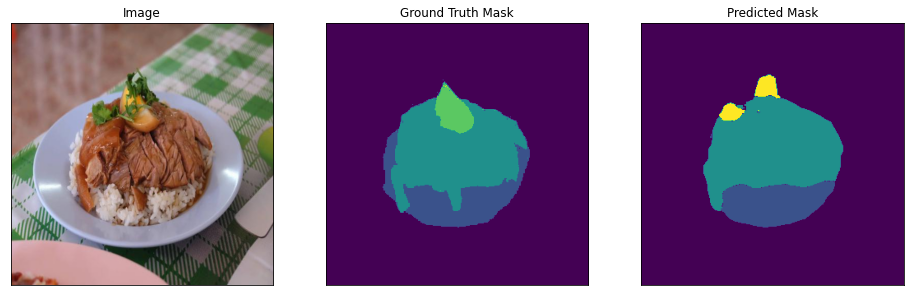

In [ ]:
for i in range(9):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    gt_mask = np.transpose(gt_mask, (1, 2, 0))
    pr_mask = np.transpose(pr_mask, (1, 2, 0))

    
    gt_mask_gray = np.zeros((gt_mask.shape[0],gt_mask.shape[1]))

    for ii in range(gt_mask.shape[2]):
        gt_mask_gray = gt_mask_gray + 1/gt_mask.shape[2]*ii*gt_mask[:,:,ii]
    
    pr_mask_gray = np.zeros((pr_mask.shape[0],pr_mask.shape[1]))
    for ii in range(pr_mask.shape[2]):
        pr_mask_gray = pr_mask_gray + 1/pr_mask.shape[2]*ii*pr_mask[:,:,ii]
    
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask_gray, 
        predicted_mask=pr_mask_gray
    )


In [ ]:
from sklearn.metrics import confusion_matrix
all_class_stack = np.zeros(7)
class_stack = np.zeros(7)

In [ ]:
for train_img in train_dataset:
  x = train_img[0]
  x = np.expand_dims(x, axis=0)
  
  image_vis = train_img[0].astype('uint8')
  image, gt_mask = train_img
  
  gt_mask = gt_mask.squeeze()
  
  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  pr_mask = model.predict(x_tensor)
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())
  gt_mask = np.transpose(gt_mask, (1, 2, 0))
  pr_mask = np.transpose(pr_mask, (1, 2, 0))

  y_true = np.argmax(gt_mask, axis=-1)
  y_pred = np.argmax(pr_mask, axis=-1)
  y_pred = y_pred.flatten()
  y_true = y_true.flatten()
  score = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
  all_class_stack += np.sum(score, axis=-1)
  
  class_stack += score.diagonal()

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [ ]:
per_pixel_accuracy = class_stack/all_class_stack*100
per_pixel_accuracy

array([99.39495536, 88.62961843, 94.98197346, 93.89280422, 94.11315726,
       96.36231582,  0.        ])

In [ ]:
ws.insert_row(list(per_pixel_accuracy)[1:])

{'spreadsheetId': '15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps',
 'updatedCells': 6,
 'updatedColumns': 6,
 'updatedRange': "'Unet++ resnet101'!A1:F1",
 'updatedRows': 1}

In [ ]:
cols = ['train_rice', 'train_meat', 'train_egg', 'train_vegetable', 'train_beverage', 'train_etc']
ws.insert_row(cols)

{'spreadsheetId': '15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps',
 'updatedCells': 6,
 'updatedColumns': 6,
 'updatedRange': "'Unet++ resnet101'!A1:F1",
 'updatedRows': 1}

In [ ]:
all_class_stack = np.zeros(7)
class_stack = np.zeros(7)

In [ ]:
image.shape

(3, 320, 320)

In [ ]:
for train_img in valid_dataset:
  x = train_img[0]
  x = np.expand_dims(x, axis=0)
  
  image_vis = train_img[0].astype('uint8')
  image, gt_mask = train_img
  
  gt_mask = gt_mask.squeeze()
  
  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
  pr_mask = model.predict(x_tensor)
  pr_mask = (pr_mask.squeeze().cpu().numpy().round())
  gt_mask = np.transpose(gt_mask, (1, 2, 0))
  pr_mask = np.transpose(pr_mask, (1, 2, 0))

  y_true = np.argmax(gt_mask, axis=-1)
  y_pred = np.argmax(pr_mask, axis=-1)
  y_pred = y_pred.flatten()
  y_true = y_true.flatten()
  score = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6])
  all_class_stack += np.sum(score, axis=-1)
  
  class_stack += score.diagonal()

/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


In [ ]:
per_pixel_accuracy = class_stack/all_class_stack*100
per_pixel_accuracy

array([97.66280923, 86.03527144, 91.31642662, 57.35376717, 83.19916762,
       67.44227304,  0.        ])

In [ ]:
ws.insert_row(list(per_pixel_accuracy)[1:])

{'spreadsheetId': '15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps',
 'updatedCells': 6,
 'updatedColumns': 6,
 'updatedRange': "'Unet++ resnet101'!A1:F1",
 'updatedRows': 1}

In [ ]:
cols = ['val_rice', 'val_meat', 'val_egg', 'val_vegetable', 'val_beverage', 'val_etc']
ws.insert_row(cols)

{'spreadsheetId': '15s5krm40QODANMOWStelQvkQs8ahtmnSLhFSN_wLMps',
 'updatedCells': 6,
 'updatedColumns': 6,
 'updatedRange': "'Unet++ resnet101'!A1:F1",
 'updatedRows': 1}

In [ ]:
ENCODER = 'timm-efficientnet-b2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['rice', 'meat', 'egg', 'vegetable', 'beverage', 'etc.']
ACTIVATION = 'softmax' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    classes=len(CLASSES)+1, 
    activation=ACTIVATION,
)

In [ ]:
import copy

In [ ]:
model.load_state_dict(copy.deepcopy(torch.load('/content/drive/MyDrive/SeniorProject/Weight/pytorch/Unet++_timm-efficientnet-b2.pt', map_location=torch.device('cpu'))))

<All keys matched successfully>

In [ ]:
model = model.double()

In [ ]:
!git clone https://github.com/nerox8664/pytorch2keras.git

Cloning into 'pytorch2keras'...
remote: Enumerating objects: 1326, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 1326 (delta 5), reused 6 (delta 2), pack-reused 1311
Receiving objects: 100% (1326/1326), 241.83 KiB | 6.72 MiB/s, done.
Resolving deltas: 100% (887/887), done.


In [ ]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [ ]:
model= model.eval()

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 2.6MB/s 
     |████████████████████████████████| 112kB 4.9MB/s 
  Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0


In [ ]:
from ../content/pytorch2keras/pytorch2keras.converter import pytorch_to_keras


SyntaxError: ignored